In [11]:
library("DESeq2")
library("biomaRt")
dir_counts <- "/home/rtu/Applied-Bioinformatics/Applied-Bioinformatics-Course/Unit2-RNAseq/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
samplesInfo <- as.data.frame(matrix(ncol=2, nrow=length(counts_files)))  
samplesInfo$samplename <- counts_files  
samplesInfo$filename <- counts_files  
samplesInfo$group <- c("mock", "ZIKV", "mock", "ZIKV", "mock", "ZIKV","mock", "ZIKV","mock", "ZIKV") 
#Remove the blank columns
samplesInfo <- samplesInfo[,-c(1:2)]
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)
#### Run the main DESeq normalization and analysis function
dds1_deseq <- DESeq(dds1)
rld <- rlog(dds1_deseq)
vsd <- varianceStabilizingTransformation(dds1_deseq)
res <- results(dds1_deseq, contrast=c("group", "ZIKV", "mock"))
summary(res)
resSorted <- res[order(res$padj),]
# EMSEMBL ids 
bm <- useMart(biomart = "ensembl")
bm <- useDataset(dataset = "hsapiens_gene_ensembl", mart = bm)
ens2genesymbol <- getBM(mart = bm, attributes = c('ensembl_gene_id', 'external_gene_name'))


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing



out of 39405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 442, 1.1%
LFC < 0 (down)     : 632, 1.6%
outliers [1]       : 29, 0.074%
low counts [2]     : 20077, 51%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Installing libraries
```
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db", version = "3.8")
BiocManager::install("clusterProfiler", version = "3.8")
```

In [3]:
library(clusterProfiler)
library(org.Hs.eg.db)


clusterProfiler v3.10.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:DelayedArray’:

    simplify

Loading required package: AnnotationDbi



## Volcano Plot
Let's redo the volcano plot we had used before. 

This time however let's highlight the differentially expressed genes with a **fold change >= 2** and **p-value <= 0.01**.

Let's remove NAs from resSorted$padj

In [4]:
resFilteredSorted <- resSorted[complete.cases(resSorted$padj),]
dim(resFilteredSorted)

[1] 19299     6

Let's create a column "selected" an set value to **TRUE** or **FALSE** based on whether they satisfy our conditions.

In [5]:
resFilteredSorted[,"selected"] <- FALSE
resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1, "selected"] <- TRUE

Let's now plot the volcano plot. log2Foldchange on the xaxis and -log10(padj) on yaxis.

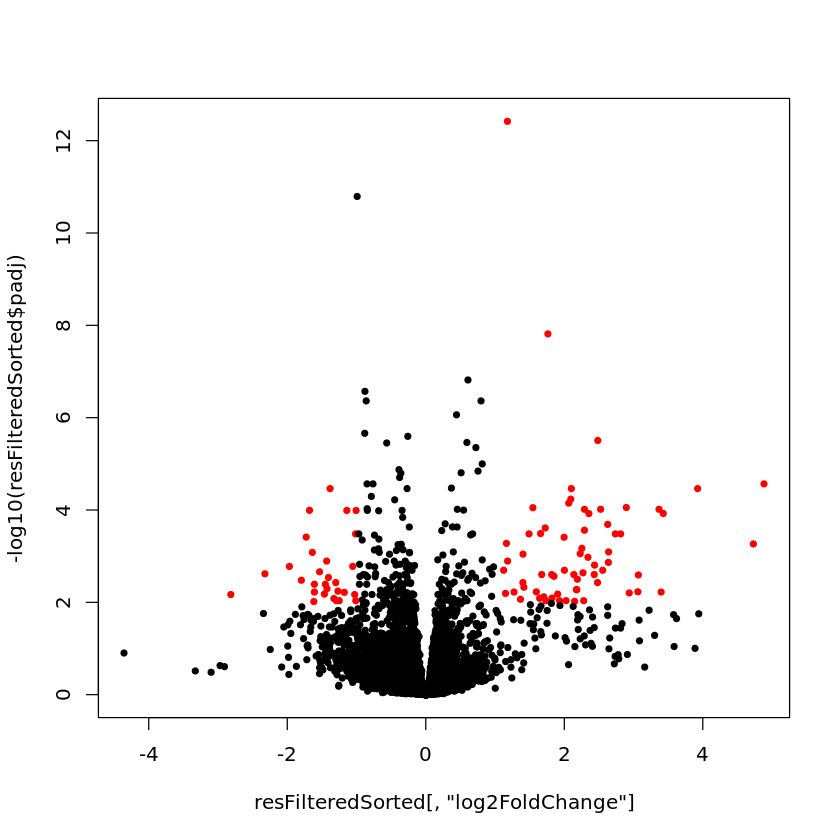

In [6]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)

Let's try and plot the text for each gene. We've already retrieved the symbol for the ENSEMBL id using the *getBM()* function in the bioMart package.

In [7]:
# Select rows from resFilteredSort that match out conditions.
df.selected <- resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1,]
# Loop over ens2genesymbol dataframe that was created before to get the gene name for each ENSEMBL ID
df.labels <- sapply(rownames(df.selected), function(x){
    ens2genesymbol[ens2genesymbol["ensembl_gene_id"]==x,"external_gene_name"]
}) #I don't understand this bit. 

Now let's plot!

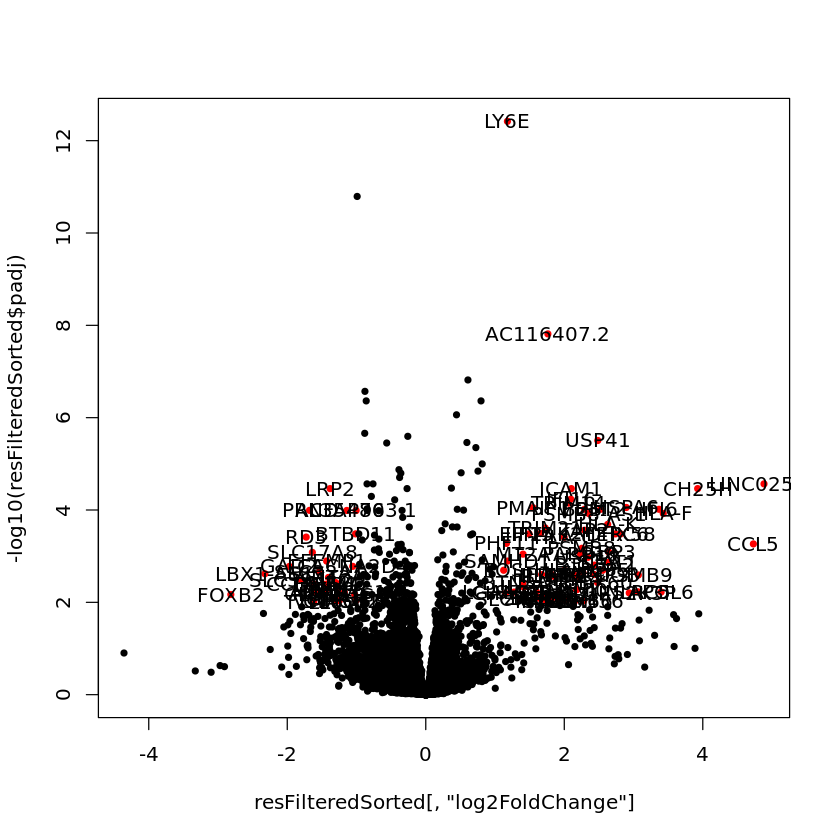

In [8]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)
text(df.selected[,"log2FoldChange"], -log10(df.selected$padj), labels = df.labels)

Let's now create a heatmap showing the groups using the *pheatmap()* function.

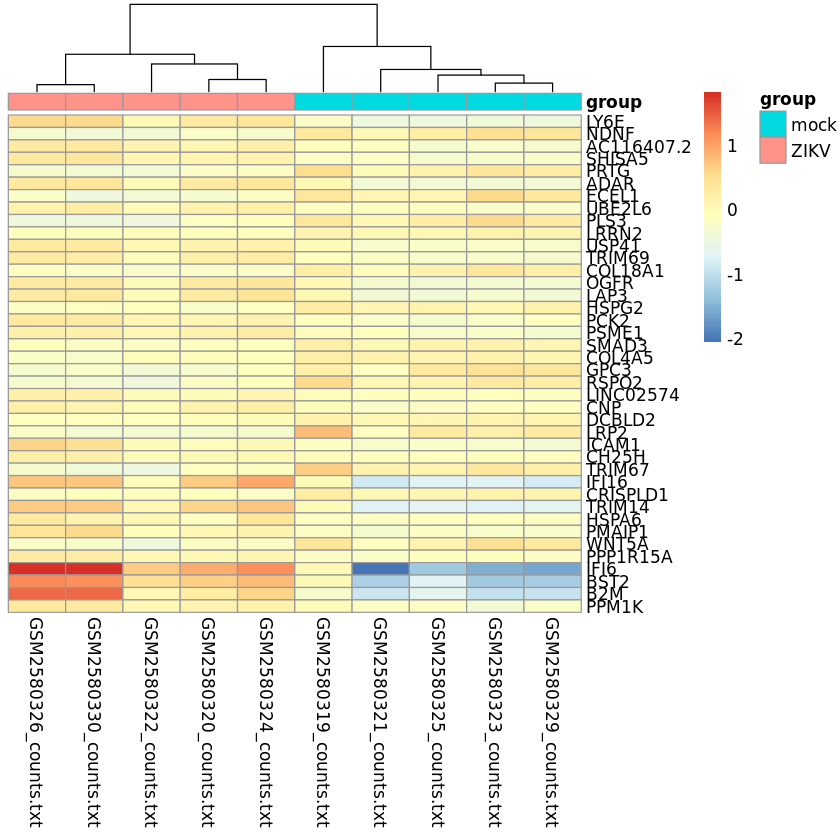

In [12]:
library(pheatmap)
df <- data.frame(colData(rld)[,"group"])
rownames(df) <- rownames(colData(rld))
colnames(df) <- c("group")

ngenes <- 40
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
rownames(mat) <- sapply(rownames(resSorted)[1:ngenes], function(x){
    return(ens2genesymbol[ens2genesymbol[,"ensembl_gene_id"]==x,"external_gene_name"]);
})

pheatmap(mat,
        annotation_col = df,
        cluster_cols = T,
        cluster_rows=F)

## Go enrichment

Let's now map the ENSEMBL ids to GO ids using the *bitr()* function.

In [13]:
head(resFilteredSorted)

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 6 rows and 7 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
ENSG00000160932 1272.50331037256   1.17891189518249  0.138773859559314
ENSG00000173376 670.426905675794 -0.990658645952052  0.124401432409426
ENSG00000277511 65.7046886547319   1.76335887902614  0.251549658364627
ENSG00000164054 6869.16254260398  0.608981568731362 0.0917295350493488
ENSG00000166450 723.956481448464  -0.87837221325576  0.134694305515951
ENSG00000160710 19383.7498794449  0.797871194715987  0.124570990142925
                             stat               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000160932  8.49520146608454 1.97589882401833e-17 3.81328714047298e-13
ENSG00000173376 -7.96340224356604 1.67372250394126e-15 1.61505853017812e-11
ENSG00000

In [14]:
gomap <- bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, drop = TRUE)

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, :
“26.43% of input gene IDs are fail to map...”

In [15]:
nrow(bitr(rownames(resFilteredSorted), "ENSEMBL", "ENSEMBLPROT", org.Hs.eg.db, drop = TRUE))

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "ENSEMBLPROT", org.Hs.eg.db, :
“77.46% of input gene IDs are fail to map...”

[1] 17164

Let's now select the unique EMSEMBL and GO id pairs from the Molecular Function(MF) domain.

In [16]:
gomap.f <- gomap[gomap$ONTOLOGY=="MF",]
gomap.f <- unique(gomap.f[,c("ENSEMBL", "GO")])

In [17]:
head(gomap.f)

,ENSEMBL,GO
6,ENSG00000160932,GO:0030550
12,ENSG00000173376,GO:0005539
16,ENSG00000173376,GO:0008201
27,ENSG00000164054,GO:0005515
40,ENSG00000166450,GO:0038023
43,ENSG00000160710,GO:0003677


Let's now get the human readable descriptions of the GO ids.

In [18]:
gomap.descriptions <- go2term(unique(gomap.f$GO))
head(gomap.descriptions)

go_id,Term
GO:0044183,protein binding involved in protein folding
GO:0051082,unfolded protein binding
GO:0003756,protein disulfide isomerase activity
GO:0015036,disulfide oxidoreductase activity
GO:0000010,trans-hexaprenyltranstransferase activity
GO:0000014,single-stranded DNA endodeoxyribonuclease activity


Let's now create a new column, "GO_TERM" in the gomap.f dataframe and add the description there.

In [20]:
gomap.f$GO_TERM <- sapply(gomap.f$GO, function(x){
    return(gomap.descriptions[gomap.descriptions$go_id==x,"Term"]);
})

In [21]:
head(gomap.f)

,ENSEMBL,GO,GO_TERM
6,ENSG00000160932,GO:0030550,acetylcholine receptor inhibitor activity
12,ENSG00000173376,GO:0005539,glycosaminoglycan binding
16,ENSG00000173376,GO:0008201,heparin binding
27,ENSG00000164054,GO:0005515,protein binding
40,ENSG00000166450,GO:0038023,signaling receptor activity
43,ENSG00000160710,GO:0003677,DNA binding


Let's get a table of the counts of each GO term

In [22]:
gomap.f.table <- table(gomap.f$GO_TERM)
# Sort table by count
gomap.f.table <- gomap.f.table[order(gomap.f.table, decreasing=TRUE)]

Let's make a piechart of the top 20 GO terms using the table!

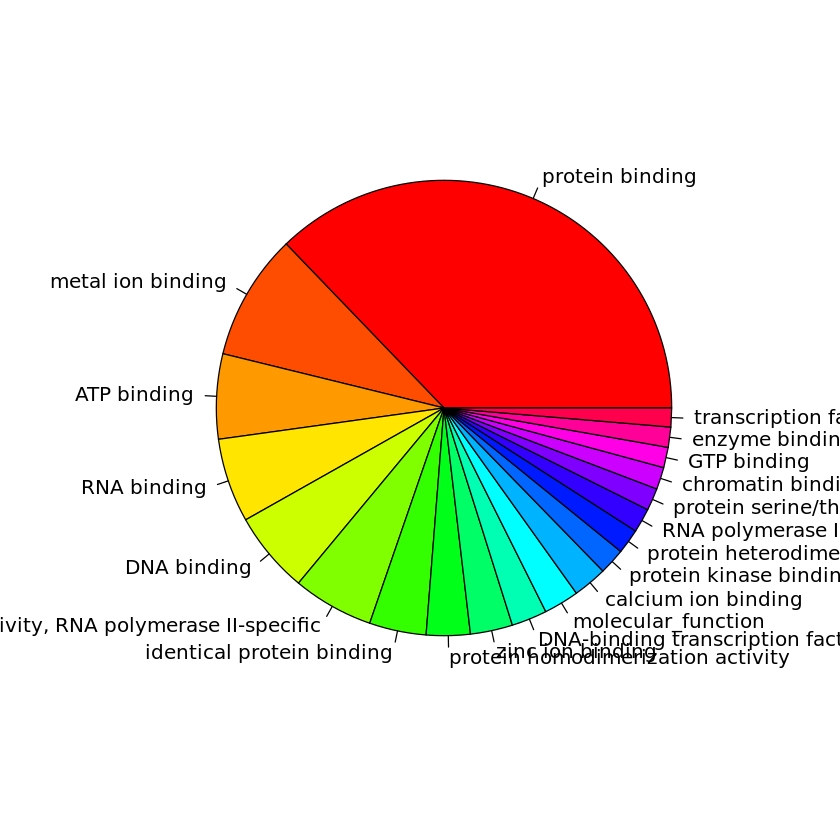

In [23]:
# raindow is just a colorscheme.
pie(gomap.f.table[1:20], col = rainbow(20))

### The piechart above is NOT an enrichment.

It simply tells us how the differentially expressed genes relate to ontology terms.

Let's now try and do a very basic **GO enrichment analysis**. 

We now have to pick a set of "background genes" to compare our differentially expresssed genes against. Let's first plot the mean normalized counts for each gene.

In [24]:
head(resSorted)

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 6 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
ENSG00000160932 1272.50331037256   1.17891189518249  0.138773859559314
ENSG00000173376 670.426905675794 -0.990658645952052  0.124401432409426
ENSG00000277511 65.7046886547319   1.76335887902614  0.251549658364627
ENSG00000164054 6869.16254260398  0.608981568731362 0.0917295350493488
ENSG00000166450 723.956481448464  -0.87837221325576  0.134694305515951
ENSG00000160710 19383.7498794449  0.797871194715987  0.124570990142925
                             stat               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000160932  8.49520146608454 1.97589882401833e-17 3.81328714047298e-13
ENSG00000173376 -7.96340224356604 1.67372250394126e-15 1.61505853017812e-11
ENSG00000

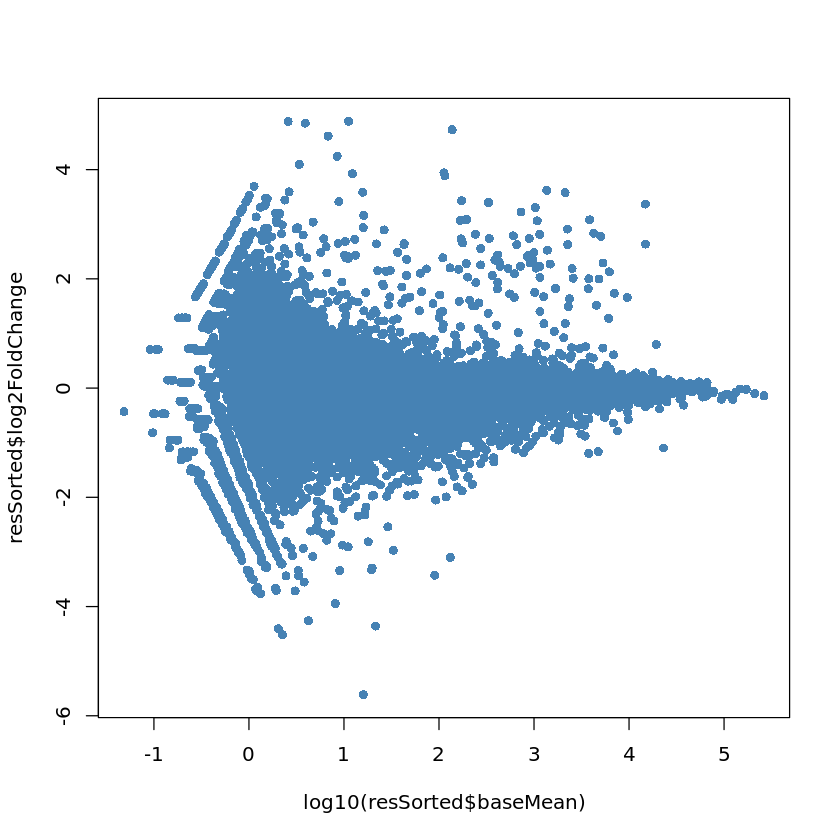

In [25]:
plot(log10(resSorted$baseMean), resSorted$log2FoldChange, pch=16, col="steelblue")

Let's now throw out all genes with mean normalized count <= 10 and redo the above plot.

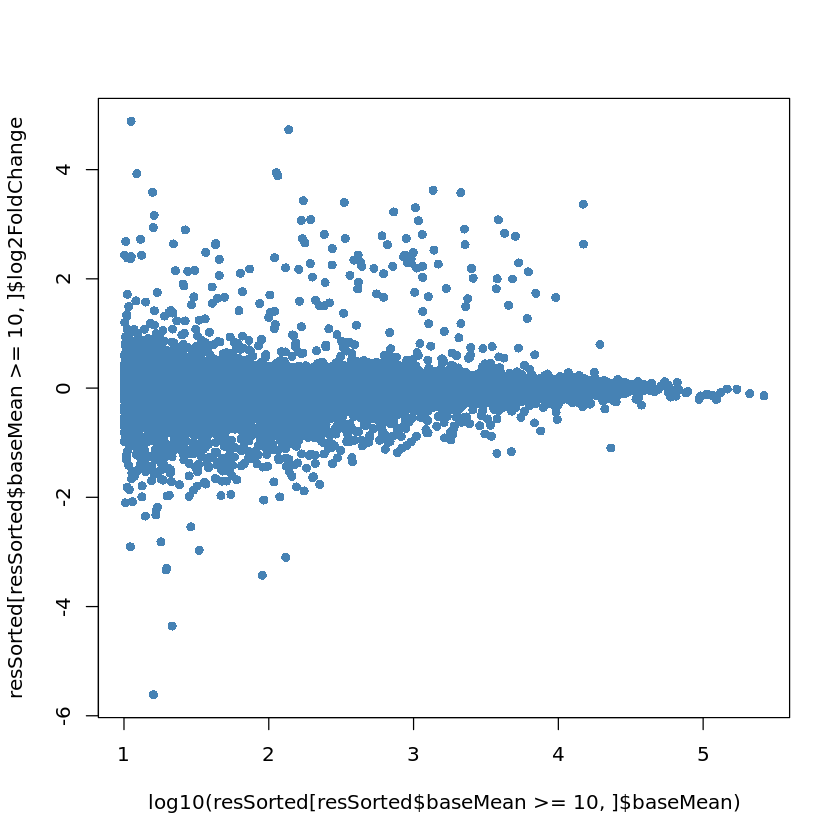

In [26]:
plot(log10(resSorted[resSorted$baseMean >= 10,]$baseMean), resSorted[resSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))

To quickly do a spot check let's pull out a gene with normalized mean count < 10 and see which tissues it is expressed in on the [GTEx](https://gtexportal.org/home/) database.

In [27]:
resSorted[resSorted$baseMean <10,]

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 39158 rows and 6 columns
                         baseMean      log2FoldChange             lfcSE
                        <numeric>           <numeric>         <numeric>
ENSG00000000005  5.04046214948513  -0.222824042163977  0.60502767976635
ENSG00000000938  9.09570444294417    1.69835160225518  0.55589697378911
ENSG00000000971  4.87903573496422  -0.334237763940526 0.811538484194621
ENSG00000001626  9.44023828574957   -1.41667623200054 0.449035674272689
ENSG00000002726 0.327440442145706    1.88544623237614  2.43786598673708
...                           ...                 ...               ...
ENSG00000285989                 0                  NA                NA
ENSG00000285990  0.64409182311204 -0.0904696693489324  1.93947097133187
ENSG00000285991  1.86620939086427    1.35727498013794  1.05083653242207
ENSG00000285992                 0                  NA                NA
ENSG000002859

Let's do the inverse now. This data was obtained by sequencing cerebral organoids that  recapitulate fetal brain development. Let's look at some differentially expressed genes in the brain on GTEx and then see how they're expressed in this data.

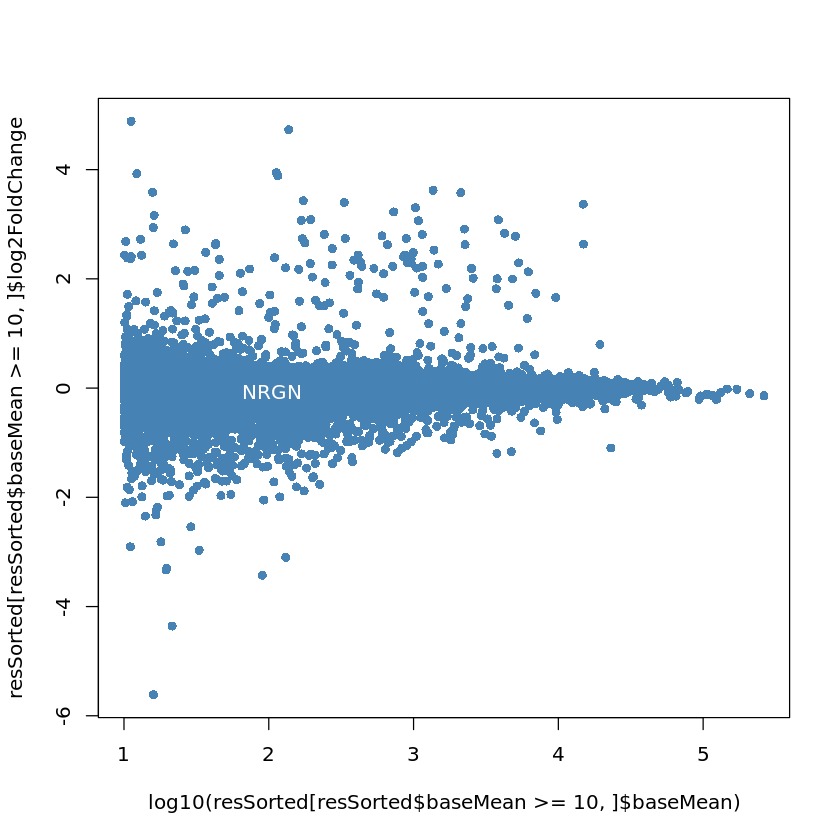

In [28]:
plot(log10(resSorted[resSorted$baseMean >= 10,]$baseMean), resSorted[resSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))
text(log10(resSorted["ENSG00000154146",]$baseMean), resSorted["ENSG00000154146",]$log2FoldChange, labels = c("NRGN"), col="white")

To generate *resFilteredSorted* we removed any genes for which padj was NA. 

Mote details on why padj might be set to NA are here in the [vignette](https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

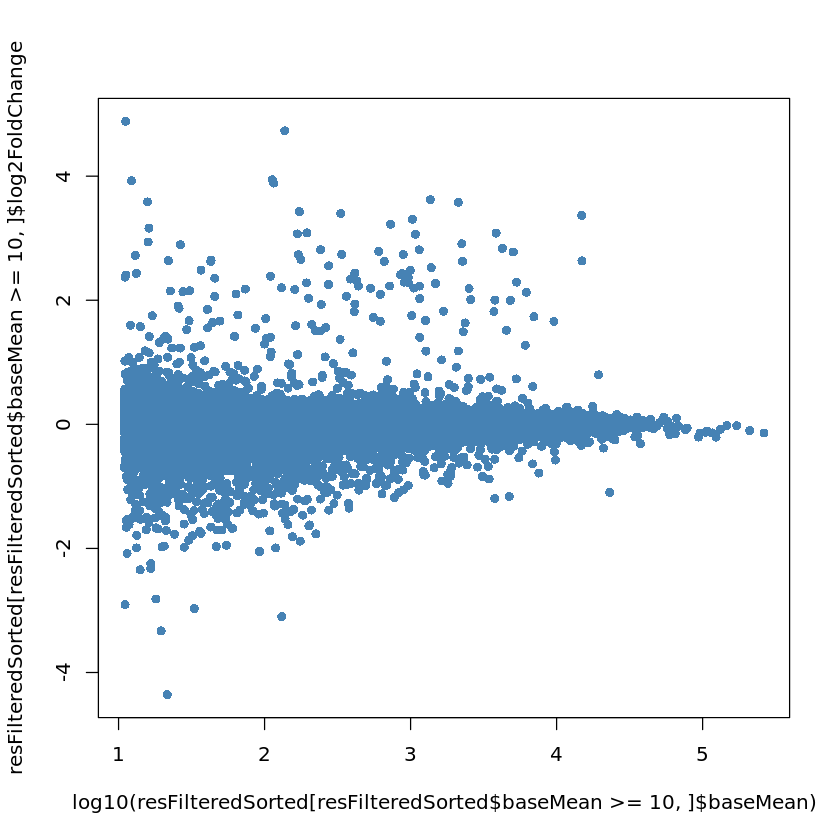

In [29]:
plot(log10(resFilteredSorted[resFilteredSorted$baseMean >= 10,]$baseMean), resFilteredSorted[resFilteredSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))


We see in the above plot that DeSeq2 has already excluded a number of genes with low counts from the model.


Let's take a look at the number of genes we are picking as our background and the number of differentially expressed genes.

In [30]:
nrow(resSorted)
nrow(resFilteredSorted)
nrow(resSorted[resSorted$baseMean >=10,])
nrow(resFilteredSorted[abs(resFilteredSorted$log2FoldChange) >= 1 & resFilteredSorted$padj<=0.05,])

[1] 58735

[1] 19299

[1] 19577

[1] 182

In [31]:
resFilteredSorted.diff <- resFilteredSorted[resFilteredSorted$log2FoldChange >= 1 & resFilteredSorted$padj<=0.05,]

Let's actually do an enrichment now. We'll use the enrichGo() function from clusterProfiler. 

**Note**: "universe" parameter is actually the background that we pick.

In [34]:
ego <- enrichGO(gene = rownames(b),
                universe = rownames(resFilteredSorted),
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
               maxGSSize = 5000,
               minGSSize = 10)

ERROR: Error in rownames(b): object 'b' not found


In [33]:
head(ego)

ERROR: Error in head(ego): object 'ego' not found


Now, let's create a plot to visualize these GO categories. Let's use the built in dotplot() function formclusterProfiler

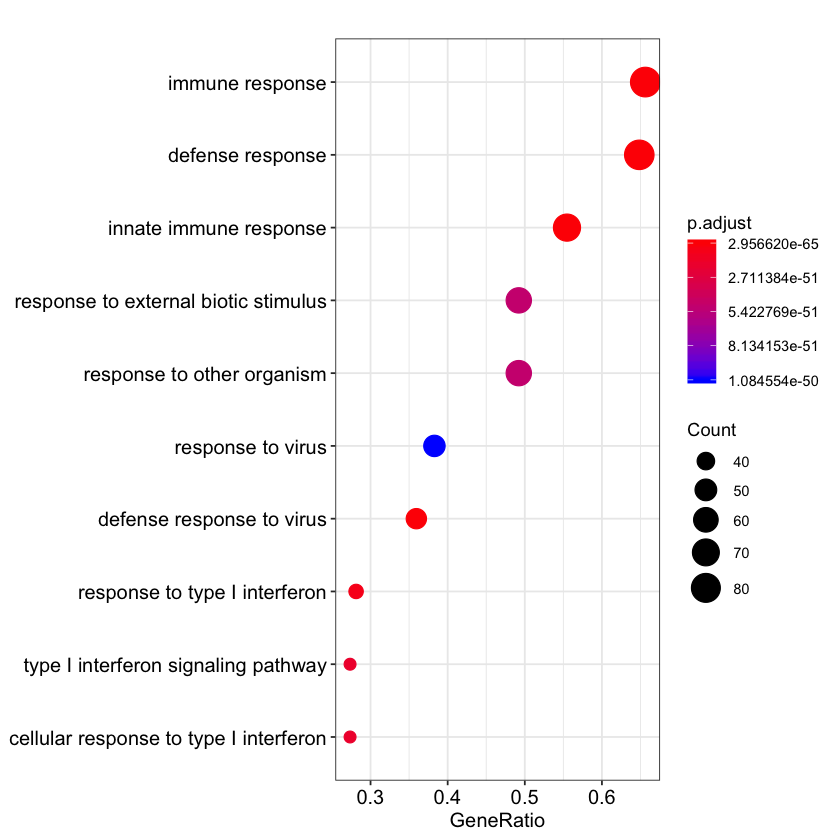

In [140]:
dotplot(ego, showCategory=10)